<a href="https://colab.research.google.com/github/andisutrakhusnulkarima/DeepLearning/blob/main/Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [50/500], Loss: 0.5783
Epoch [100/500], Loss: 0.5527
Epoch [150/500], Loss: 0.5429
Epoch [200/500], Loss: 0.5392
Epoch [250/500], Loss: 0.5350
Epoch [300/500], Loss: 0.5291
Epoch [350/500], Loss: 0.5223
Epoch [400/500], Loss: 0.5177
Epoch [450/500], Loss: 0.5092
Epoch [500/500], Loss: 0.5010


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📊 PyTorch Model Evaluation:
Accuracy: 0.7325
Precision: 0.3333
Recall: 0.0507
F1-Score: 0.0880
AUC: 0.5080

📊 TensorFlow Model Evaluation:
Accuracy: 0.6511
Precision: 0.2934
Recall: 0.2630
F1-Score: 0.2774
AUC: 0.5233


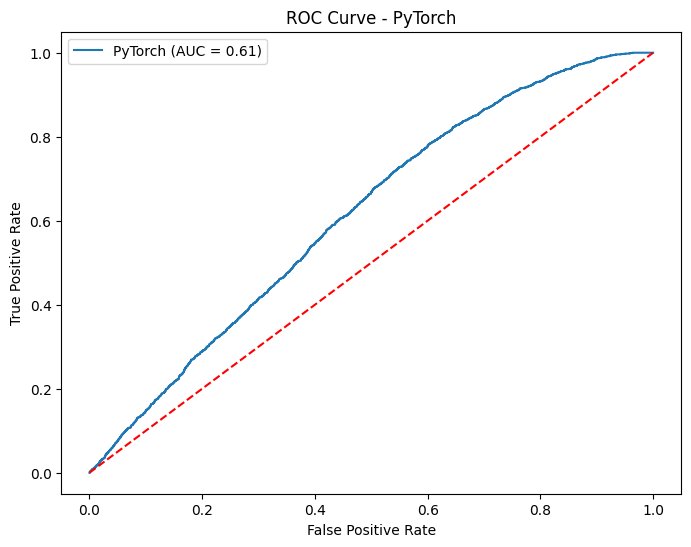

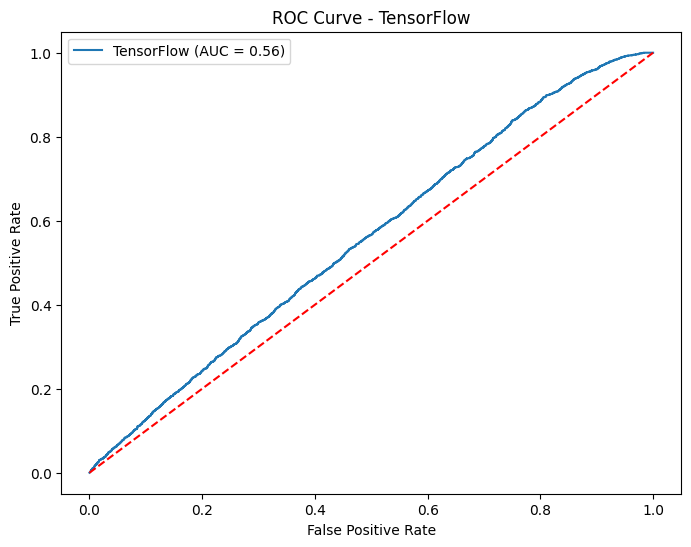

In [1]:
#Andi Sutra Khusnul  Karima/1103220033
#1. Buat model Deep learning (PyTorch and Tensorflow).
#2. Bandingkan Matriks Evaluasi (Akurasi,Presisi,Recall,F1Squared, AUC, ROC). Matriks Evaluasi mana yang terbaik? Jelaskan!
#3. Beri penjelasan untuk setiap persamaan matematika yang ada.

import pandas as pd
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# .Download Dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/Dataset/income.csv"
response = requests.get(url)
with open("income.csv", "wb") as file:
    file.write(response.content)

df = pd.read_csv("income.csv")
df.columns = df.columns.str.strip()  # Bersihkan spasi tersembunyi

# Tangani Missing Values
imputer = SimpleImputer(strategy='mean')
df.loc[:, df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df.select_dtypes(include=[np.number]))

#  Konversi Kategori ke Numeric**
df = pd.get_dummies(df, drop_first=True)

#  Pilih Target Secara Dinamis (Menghindari KeyError)**
income_cols = df.filter(like="income").columns.tolist()
if not income_cols:
    raise ValueError(" Kolom target tidak ditemukan!")
y = df[income_cols[0]]  # Pilih kolom pertama yang mengandung 'income'
X = df.drop(columns=income_cols)

#  Normalisasi Fitur**
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

#  Split Dataset**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# . Konversi ke Tensor PyTorch**
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).squeeze()
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).squeeze()

#  Definisi Model PyTorch**
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x

#  Training Model PyTorch**
model = NeuralNetwork(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

#  Prediksi PyTorch**
model.eval()
y_pred_pytorch = model(X_test_tensor).detach().numpy().flatten()
y_pred_pytorch_class = (y_pred_pytorch > 0.5).astype(int)

#  Model TensorFlow**
tf_model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

tf_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
tf_model.fit(X_train, y_train, epochs=500, batch_size=64, verbose=0, validation_data=(X_test, y_test))

#  Prediksi TensorFlow**
y_pred_tf = tf_model.predict(X_test).flatten()
y_pred_tf_class = (y_pred_tf > 0.5).astype(int)

#  Evaluasi Model**
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1-Score": f1_score,
    "AUC": roc_auc_score
}

def evaluate_model(y_true, y_pred, model_name):
    print(f'\n📊 {model_name} Evaluation:')
    for name, metric in metrics.items():
        score = metric(y_true, y_pred) if name != "AUC" else metric(y_true, y_pred.astype(float))
        print(f'{name}: {score:.4f}')

evaluate_model(y_test, y_pred_pytorch_class, "PyTorch Model")
evaluate_model(y_test, y_pred_tf_class, "TensorFlow Model")

#  Plot ROC Curve PyTorch**
fpr_pytorch, tpr_pytorch, _ = roc_curve(y_test, y_pred_pytorch)

plt.figure(figsize=(8,6))
plt.plot(fpr_pytorch, tpr_pytorch, label=f'PyTorch (AUC = {roc_auc_score(y_test, y_pred_pytorch):.2f})')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - PyTorch')
plt.legend()
plt.show()

#  Plot ROC Curve TensorFlow**
fpr_tf, tpr_tf, _ = roc_curve(y_test, y_pred_tf)

plt.figure(figsize=(8,6))
plt.plot(fpr_tf, tpr_tf, label=f'TensorFlow (AUC = {roc_auc_score(y_test, y_pred_tf):.2f})')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TensorFlow')
plt.legend()
plt.show()
